In [11]:
# Imports: data, model, metrics, and a clean preprocessing pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import seaborn as sns  # we’ll load Titanic directly from seaborn

plt.rcParams["figure.figsize"] = (6.5, 5)
plt.rcParams["axes.grid"] = True
np.random.seed(42)


In [12]:
# Load the seaborn Titanic dataset
df = sns.load_dataset("titanic")
print("Shape:", df.shape)
df.head()


Shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [13]:
# Pick features and the target
use_cols = ["pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]
df_small = df[use_cols + ["survived"]].copy()

# Ensure the target is 0/1 ints
df_small["survived"] = df_small["survived"].astype(int)

X = df_small[use_cols]
y = df_small["survived"]

print("Feature dtypes:\n", X.dtypes)
print("\nClass balance:\n", y.value_counts(normalize=True).round(3))


Feature dtypes:
 pclass        int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
dtype: object

Class balance:
 survived
0    0.616
1    0.384
Name: proportion, dtype: float64


In [14]:
# Train/test split with stratification to preserve survival ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
X_train.shape, X_test.shape


((668, 7), (223, 7))

In [15]:
# Build the preprocessing + RandomForest pipeline

# 1) Identify column types
categorical = ["sex", "embarked"]
numeric     = ["pclass", "age", "sibsp", "parch", "fare"]

# 2) Define transformers: impute missing values, then encode/pass-through
cat_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),           # fill missing 'sex'/'embarked'
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

num_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median"))                   # fill missing ages/fares robustly
])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, categorical),
        ("num", num_pipe, numeric),
    ],
    remainder="drop"
)

# 3) Define the model
rf = RandomForestClassifier(
    n_estimators=400,        # enough trees for stability
    max_depth=None,         # let trees grow; forest averaging controls variance
    max_features="sqrt",    # decorrelate trees by limiting features per split
    min_samples_leaf=1,     # keep defaults simple to start
    n_jobs=-1,              # use all cores
    random_state=42
)

# 4) Bundle into one pipeline so preprocessing and model always move together
model = Pipeline(steps=[("prep", preprocess), ("rf", rf)])
model


,steps,"[('prep', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Accuracy:  0.744
Precision: 0.679
Recall:    0.640
F1-score:  0.659

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.80       137
           1       0.68      0.64      0.66        86

    accuracy                           0.74       223
   macro avg       0.73      0.72      0.73       223
weighted avg       0.74      0.74      0.74       223



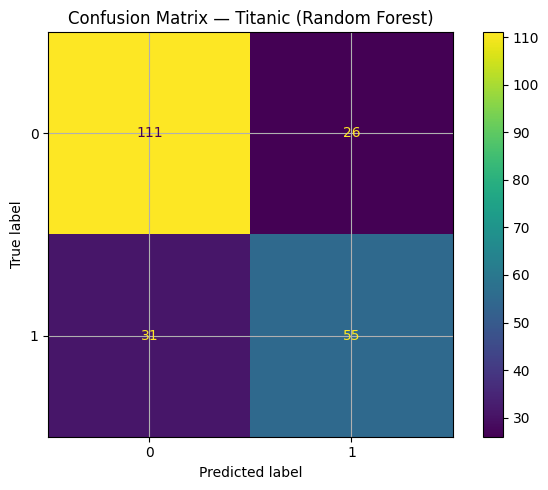

In [16]:
# Fit and evaluate
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")  # when we predict 'survived', how often are we right?
print(f"Recall:    {rec:.3f}")   # of all who survived, how many did we catch?
print(f"F1-score:  {f1:.3f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix — Titanic (Random Forest)")
plt.tight_layout(); plt.show()


In [17]:
# Which inputs mattered? (impurity-based feature importance)
# Get transformed feature names from the pipeline
ohe = model.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"]
cat_names = list(ohe.get_feature_names_out(categorical))
feature_names = cat_names + numeric

rf_trained = model.named_steps["rf"]
importances = pd.Series(rf_trained.feature_importances_, index=feature_names).sort_values(ascending=False)
importances.to_frame("importance").head(12)


,importance
fare,0.261594
age,0.238775
sex_female,0.148929
sex_male,0.143733
pclass,0.083149
sibsp,0.047948
parch,0.040764
embarked_S,0.015057
embarked_C,0.013407
embarked_Q,0.006645


In [18]:
# Light tuning: small grid over a few knobs that actually move the needle
param_grid = {
    "rf__n_estimators": [300, 600],
    "rf__max_depth": [None, 8, 12],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", 0.7]
}

grid = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring="f1",   # balance precision and recall
    cv=5,
    n_jobs=-1,
    verbose=0
)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred_tuned = best_model.predict(X_test)

acc2  = accuracy_score(y_test, y_pred_tuned)
prec2, rec2, f12, _ = precision_recall_fscore_support(y_test, y_pred_tuned, average="binary", zero_division=0)

print("Best params:", grid.best_params_)
print(f"Tuned — Accuracy: {acc2:.3f} | Precision: {prec2:.3f} | Recall: {rec2:.3f} | F1: {f12:.3f}")


Best params: {'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 600}
Tuned — Accuracy: 0.785 | Precision: 0.764 | Recall: 0.640 | F1: 0.696


In [19]:
# Save the full pipeline for reuse (preprocessing + model)
import joblib
joblib.dump(best_model if 'best_model' in globals() else model, "titanic_random_forest.joblib")
print("Saved to titanic_random_forest.joblib")


Saved to titanic_random_forest.joblib
